**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import load_diabetes, load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, explained_variance_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

**Code**

In [2]:
class KMeans:
  def __init__(self, k=3, max_iters=100, tol=1e-4, init_method='random', dist_metric='euclidean', verbose=False):
    self.k = k
    self.max_iters = max_iters
    self.tol = tol
    self.init_method = init_method
    self.dist_metric = dist_metric
    self.verbose = verbose

  def _initialize_centroids(self, X):
    if self.init_method == 'random':
      # Random initialization within the data bounds
      min_vals, max_vals = np.min(X, axis=0), np.max(X, axis=0)
      centroids = np.array([np.random.uniform(min_vals[i], max_vals[i], self.k) for i in range(X.shape[1])]).T
    elif self.init_method == 'kmeans++':
      # K-Means++ initialization
      centroids = [X[np.random.randint(len(X))]]
      for _ in range(1, self.k):
        dist_sq = np.min([np.linalg.norm(X - c, axis=1)**2 for c in centroids], axis=0)
        prob = dist_sq / dist_sq.sum()
        next_centroid = X[np.random.choice(len(X), p=prob)]
        centroids.append(next_centroid)
      centroids = np.array(centroids)
    return centroids

  def _compute_distance(self, a, b):
    if self.dist_metric == 'euclidean':
      return np.linalg.norm(a - b)
    elif self.dist_metric == 'manhattan':
      return np.sum(np.abs(a - b))

  def _assign_clusters(self, X, centroids):
    distances = np.zeros((X.shape[0], self.k))
    for i, centroid in enumerate(centroids):
      distances[:, i] = np.linalg.norm(X - centroid, axis=1) if self.dist_metric == 'euclidean' else np.sum(np.abs(X - centroid), axis=1)
    return np.argmin(distances, axis=1)

  def _compute_centroids(self, X, labels):
    centroids = np.zeros((self.k, X.shape[1]))
    for i in range(self.k):
      points_in_cluster = X[labels == i]
      if len(points_in_cluster) > 0:
        centroids[i] = np.mean(points_in_cluster, axis=0)
      else:
        # Handle empty clusters by reinitializing the centroid randomly
        centroids[i] = X[np.random.randint(len(X))]
    return centroids

  def fit(self, X, visualize=False):
    self.centroids = self._initialize_centroids(X)
    for iteration in range(self.max_iters):
        labels = self._assign_clusters(X, self.centroids)
        new_centroids = self._compute_centroids(X, labels)
        # Check for convergence based on centroid movement
        if np.linalg.norm(self.centroids - new_centroids) < self.tol:
          if self.verbose:
            print(f"Converged in {iteration+1} iterations.")
          break
        self.centroids = new_centroids
        # Optionally visualize clustering at each iteration
        if visualize:
          self._visualize_clusters(X, labels, iteration+1)
        if self.verbose:
          print(f"Iteration {iteration+1}: Centroid movement = {np.linalg.norm(self.centroids - new_centroids)}")
    self.labels = labels

  def predict(self, X):
    return self._assign_clusters(X, self.centroids)

**Load Dataset**

In [3]:
dataset = load_iris()
x = dataset.data
y = dataset.target

In [4]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

**Train**

In [5]:
# Train
kmeans = KMeans(k=3, max_iters=100, tol=1e-3, init_method='kmeans++', dist_metric='euclidean', verbose=True)
kmeans.fit(X_train)

Iteration 1: Centroid movement = 0.0
Iteration 2: Centroid movement = 0.0
Iteration 3: Centroid movement = 0.0
Converged in 4 iterations.


**Prediction**

In [6]:
# Predicting cluster assignments
predicted_labels = kmeans.predict(X_train)
predicted_labels

array([1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 1,
       1, 2, 0, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 2,
       0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2,
       0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 0])

**Visualization**

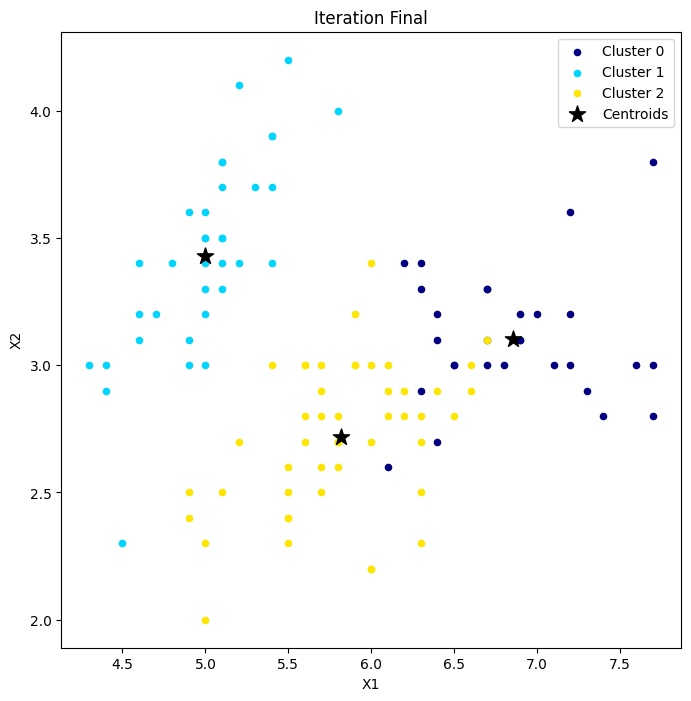

In [7]:
# Visualizing function
def _visualize_clusters(X, centroids, labels, iteration):
  df = DataFrame(dict(x=X[:, 0], y=X[:, 1], label=labels))
  colors = {i: plt.cm.jet(float(i) / max(labels + 1)) for i in range(len(centroids))}
  fig, ax = plt.subplots(figsize=(8, 8))
  for key, group in df.groupby('label'):
      group.plot(ax=ax, kind='scatter', x='x', y='y', label=f'Cluster {key}', color=colors[key])
  ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=150, c='black', label='Centroids')
  plt.title(f"Iteration {iteration}")
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.legend()
  plt.show()

# Call the function with the final centroids and labels
_visualize_clusters(X_train, kmeans.centroids, predicted_labels, "Final")